## Section 3: Integration with functional genomic annotations

In [1]:
library(tidyverse)
library(GGally)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(data.table)
library(ggpubr)
library(patchwork)
library(ggridges)
library(epitools)
library(ggExtra)
library(naniar)
library(pROC)
library(fs)
library(openxlsx)
library(ggsci)

setwd('~/work/mpra-v2')
`%notin%` <- Negate(`%in%`)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: viridisLite


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [2]:
hgConvTable = unique(fread("annotation/hgConversionTable.txt"))
mpraStats = fread("sumstats/1KG_novaSeq_DESeq2_Love_Base2.txt")

mpraStats$alleleTransform = 2^(mpraStats$log2FoldChange_allele)

mpraStats.tmp = mpraStats[,c(3,4,5,6,7,8,9,23,27,29,33,34)]
mpraStats.tmp = subset(mpraStats.tmp, haploFlag == "Base")

In [3]:
computeOddsRatios = function(labels, categories){
    
    oddsRatios = data.frame("label" = as.character(),
                        "or" = numeric(),
                        "lower" = numeric(),
                        "upper" = numeric(),
                        "midp.exact" = numeric(),
                        "fisher.exact" = numeric(),
                        "chi.square" = numeric(), stringsAsFactors = F)
    
    uniqCategories = unique(categories[!is.na(categories)])
    
    for(categ in uniqCategories){
        
        idx = which(categories == categ | is.na(categories))
        
        testTable = table(labels[idx], is.na(categories[idx])) + 1
        testOddsRatio = suppressWarnings(oddsratio(testTable, correction = T))

        estimates = testOddsRatio$measure[2,]
        pvals = testOddsRatio$p.value[2,]

        newRow = data.frame("label" = as.character(categ),
                            "or" = estimates[1],
                            "lower" = estimates[2],
                            "upper" = estimates[3],
                            "midp.exact" = pvals[1],
                            "fisher.exact" = pvals[2],
                            "chi.square" = pvals[3], stringsAsFactors = F)

        oddsRatios = rbind(oddsRatios, newRow)
        
    }
    
    oddsRatios$fisher.exact.bh = p.adjust(oddsRatios$fisher.exact, method = "BH")
    return(oddsRatios)
}

In [4]:
computeOddsRatiosVsAll = function(labels, categories){
    
    oddsRatios = data.frame("label" = as.character(),
                        "or" = numeric(),
                        "lower" = numeric(),
                        "upper" = numeric(),
                        "midp.exact" = numeric(),
                        "fisher.exact" = numeric(),
                        "chi.square" = numeric(), stringsAsFactors = F)
    
    uniqCategories = unique(categories)
    
    for(categ in uniqCategories){
        
        testTable = table(categories == categ, labels) + 1
        testOddsRatio = suppressWarnings(oddsratio(testTable, correction = T, rev = "rows"))

        estimates = testOddsRatio$measure[2,]
        pvals = testOddsRatio$p.value[2,]

        newRow = data.frame("label" = as.character(categ),
                            "or" = estimates[1],
                            "lower" = estimates[2],
                            "upper" = estimates[3],
                            "midp.exact" = pvals[1],
                            "fisher.exact" = pvals[2],
                            "chi.square" = pvals[3], stringsAsFactors = F)

        oddsRatios = rbind(oddsRatios, newRow)
        
    }
    
    oddsRatios$fisher.exact.bh = p.adjust(oddsRatios$fisher.exact, method = "BH")
    return(oddsRatios)
}

In [5]:
mpraStats.hg = merge(mpraStats[,4:5],hgConvTable,by.x=c("chrom","pos"),by.y=c("hg19_chrom","hg19_pos"))
mpraStats.hg = mpraStats.hg[,3:4]
mpraStats.hg$end = mpraStats.hg[,2] + 1
write.table(mpraStats.hg,"sumstats/mpraSites-hg38.txt",col.names = F, row.names = F, quote = F, sep = "\t")

In [ ]:
#subset(mpraStats.tmp,geneID=="ENSG00000100266" & padj_expr<5e-2 & padj_allele<5e-2) %>% filter(abs(log2FoldChange_expr)>2)
#subset(mpraStats.tmp,geneID=="ENSG00000164308" & padj_expr<5e-2 & padj_allele<5e-2) 

## ENCODE/REMAP TRANSCRIPTION FACTORS

In [6]:
remap = fread("annotation/GM12878-REMAP-mpraSites.bed",drop=3,col.names = c("hg38_chrom","hg38_pos","tf","tfScore"))
remap = merge(remap,hgConvTable,by=c("hg38_chrom","hg38_pos"))[,c(5,6,3,4)]
remap = separate_rows(remap,tf,sep=",") 

remap = remap %>% 
             group_by(hg19_chrom, hg19_pos,tf) %>% 
             summarize(tfScoreSum = max(tfScore))

mpra.remap = merge(mpraStats.tmp, remap,
                    by.x = c("chrom","pos"),
                    by.y = c("hg19_chrom","hg19_pos"),all.x = T, allow.cartesian=TRUE)

`summarise()` regrouping output by 'hg19_chrom', 'hg19_pos' (override with `.groups` argument)



In [7]:
hitLabels = ifelse(mpra.remap$padj_expr < 5e-2, "hit","nonhit")
hitLabels.high = ifelse(mpra.remap$padj_expr < 5e-10, "hit","nonhit")

oddsRatios = computeOddsRatios(hitLabels, mpra.remap$tf)
oddsRatios.high = computeOddsRatios(hitLabels.high, mpra.remap$tf)

oddsRatios$level = "normal"
oddsRatios.high$level = "high"

oddsRatios.all = rbind(oddsRatios, oddsRatios.high)

In [8]:
fwrite(oddsRatios.all, "sumstats/ENCODE-TF-OR.txt", quote = F, sep = "\t")

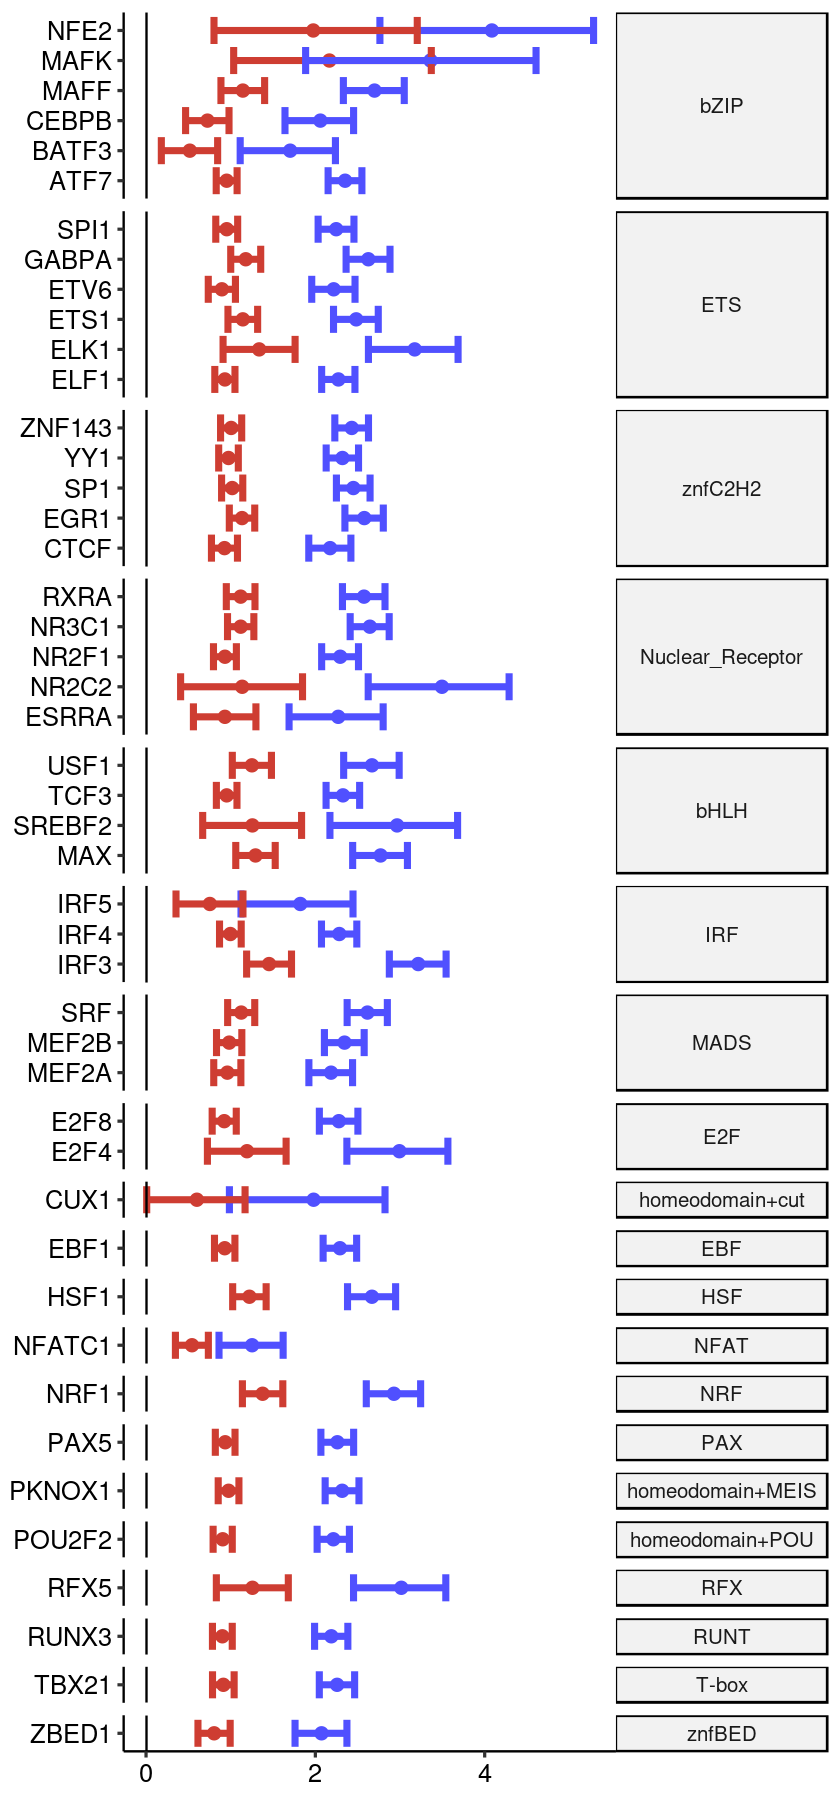

In [9]:
families = unique(fread("annotation/TF-families.txt", header=F))
family.OR = merge(oddsRatios.all,  families, by.x = "label", by.y = "V1")
family.OR = family.OR %>% 
                group_by(V2) %>% 
                mutate(n = n())
family.OR$V2 = factor(family.OR$V2,levels = unique(family.OR$V2[order(family.OR$n,decreasing = T)]))

options(repr.plot.width =7, repr.plot.height =15)
ggplot(family.OR, aes(x = log2(or),
                           y = label,
                           xmin = log2(lower),
                           xmax = log2(upper),
                           color = level)) + 
    geom_point(stat = "identity",size=3) +
    geom_errorbarh(stat = "identity",size=1.5) +
    geom_vline(aes(xintercept = 0), color = "black") + 
    theme_pubr(base_size = 15) + 
    theme(axis.title.y = element_blank(), 
          axis.title.x = element_blank()) + 
    theme(legend.position = "none") + scale_color_igv() + facet_grid(vars(V2),scales = "free",space = "free") +
    theme(strip.text.y = element_text(angle=0))

In [10]:
oddsRatios.idx = oddsRatios.all %>% 
                    group_by(label) %>% 
                    filter(all(fisher.exact.bh < 5e-2)) %>%  
                    filter(mean(or) > 5) %>%
                    unlist()

pA1 = ggplot(subset(oddsRatios.all,label %in% oddsRatios.idx), aes(x = log2(or),
                           y = reorder(label,or),
                           xmin = log2(lower),
                           xmax = log2(upper),
                           color = level)) + 
    geom_point(stat = "identity",size=3) +
    geom_errorbarh(stat = "identity",size=1.5) +
    geom_vline(aes(xintercept = 0), color = "black") + 
    theme_pubr(base_size = 15) + 
    theme(axis.title.y = element_blank(), 
          axis.title.x = element_blank()) + 
    theme(legend.position = "none") + scale_color_igv() + xlim(c(-1,7))

pA2 = ggplot(subset(oddsRatios.all,label %notin% oddsRatios.idx), aes(x = log2(or),
                           y = reorder(label,or),
                           xmin = log2(lower),
                           xmax = log2(upper),
                           color = level)) + 
    geom_point(stat = "identity",alpha=0.4) +
    geom_errorbarh(stat = "identity",alpha=0.4) +
    geom_vline(aes(xintercept = 0), color = "black") + 
    theme_pubr(base_size = 15) + 
    theme(axis.title.x = element_text("log2(odds ratio)"),
          axis.text.y = element_blank(),
          axis.ticks.y=element_blank()) + 
    xlab("log2(odds ratio)") + ylab("All Other ENCODE3 Transcription Factors")+
    theme(legend.position = "none",
          axis.title.y = element_text(vjust=-20)) + scale_color_igv() + xlim(c(-1,7))

Warning message:
“Removed 5 rows containing missing values (geom_errorbarh).”


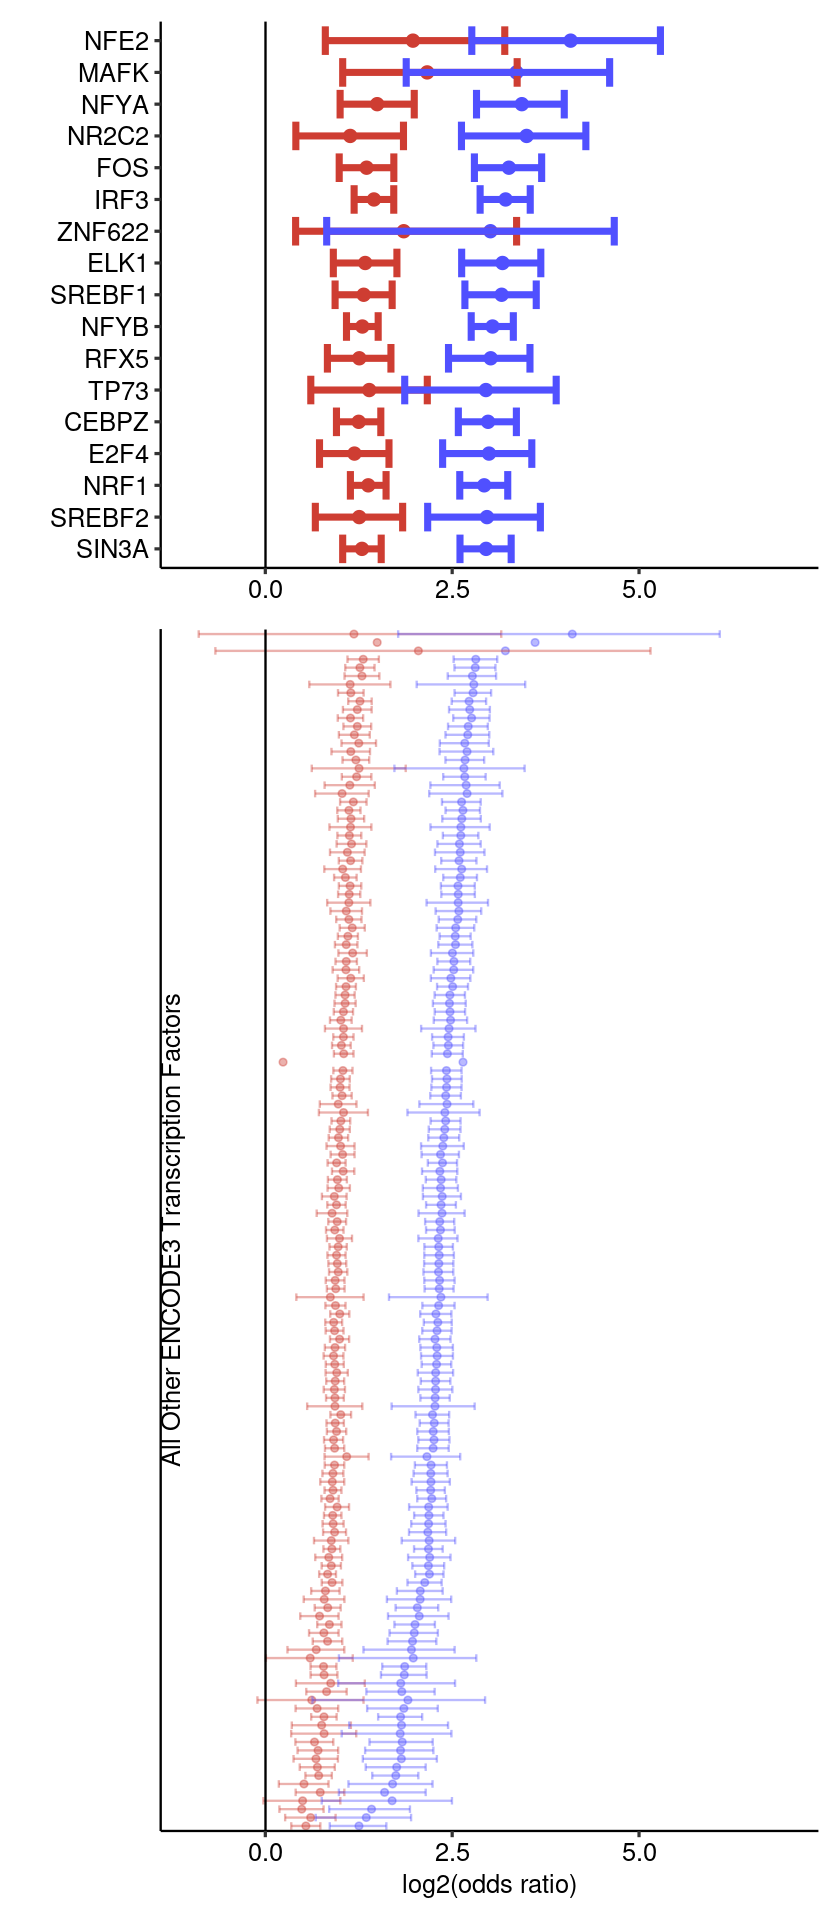

In [11]:
options(repr.plot.width = 7, repr.plot.height = 16)
pA1 / pA2 + plot_layout(design = paste0(c(rep("A\n",5),rep("B\n",11)),collapse = ""))

## ENCODE HISTONE MODIFICATIONS

In [12]:
histoneIDs = fread("annotation/histone/encodeIDs.txt", col.names = c("label","histoneID"))
histoneIDs$histoneID = gsub("-human","",histoneIDs$histoneID)

files = dir_ls(path = "annotation/histone",glob = "*bed")
names(files) = gsub("annotation/histone/","", names(files))

names(files) = gsub("-subset.bed","", names(files))

histone = files %>% map_dfr(fread, .id = "source") %>% select(-V3)
names(histone) = c("factor","chrom","pos","score")
histone = histone %>% 
    group_by(chrom,pos,factor) %>% 
    summarize(score = max(score))

mpra.histone = merge(mpraStats.tmp, histone, by = c("chrom","pos"),all.x = T)
mpra.histone$score[which(mpra.histone$score < 10)] = NA

`summarise()` regrouping output by 'chrom', 'pos' (override with `.groups` argument)



In [13]:
hitList = ifelse(mpra.histone$padj_expr<5e-2,"hit","nonhit")
hitList.high = ifelse(mpra.histone$padj_expr<5e-10,"hit","nonhit")

oddsRatios = computeOddsRatios(hitList,mpra.histone$factor)
oddsRatios.high = computeOddsRatios(hitList.high,mpra.histone$factor)

oddsRatios$group = "normal"
oddsRatios.high$group = "high"

oddsRatios = merge(oddsRatios, histoneIDs, by = "label")
oddsRatios.high = merge(oddsRatios.high, histoneIDs, by = "label")

oddsRatios$histoneID = make.unique(oddsRatios$histoneID)
oddsRatios.high$histoneID = make.unique(oddsRatios.high$histoneID)

exclude = c("ENCFF247VUO","ENCFF308WNH","ENCFF851UKZ","ENCFF682WIQ")
oddsRatios.all = rbind(oddsRatios, oddsRatios.high)

In [14]:
fwrite(oddsRatios.all, "sumstats/ENCODE-HISTONE-OR.txt", quote = F, sep = "\t")

In [15]:
pB = ggplot(data = subset(oddsRatios.all,label %notin% exclude),
            aes(x =log2(or),
                y = reorder(histoneID,log2(or)),
                xmin = log2(lower),
                xmax=log2(upper),
                color = group, group = group)) + 
    geom_point(stat = "identity",size=3) +
    geom_errorbarh(stat = "identity", size = 1.5) +
    geom_vline(aes(xintercept = 0)) + 
    theme(axis.title.y = element_blank(),
          legend.title = element_blank()) +
    theme_pubr(base_size = 15) + 
    xlab("log2(odds ratio)") + ylab("") +
    theme(legend.position = "none") +
    scale_color_igv()

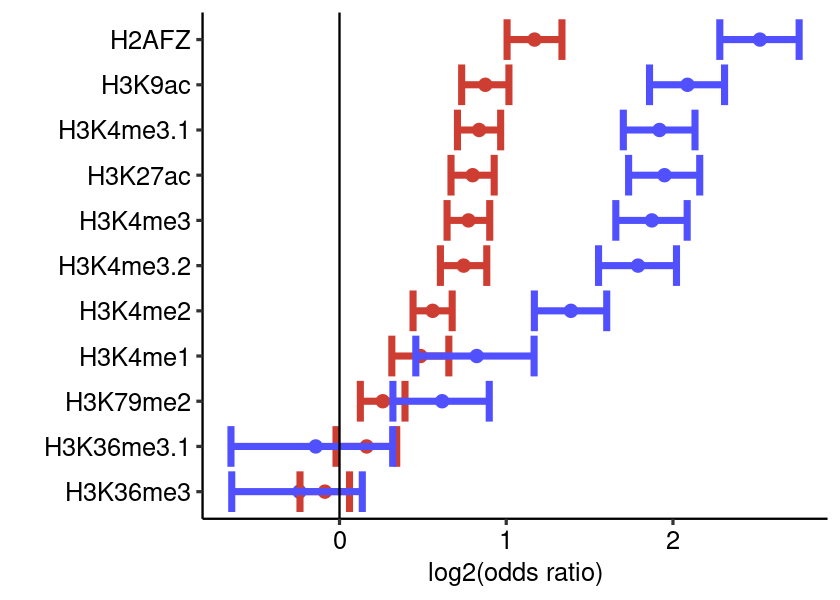

In [16]:
options(repr.plot.height = 5, repr.plot.width =7 )
pB 

## ENCODE3 CHROMATIN ACCESSIBILITY

In [17]:
encode.caGen = fread("annotation/DHS_Index_and_Vocabulary_hg38_WM20190703-subset.bed")[,-3]
names(encode.caGen) = c("chrom","pos","score","category")
encode.caGen = merge(encode.caGen, hgConvTable, by.x = c("chrom","pos"), by.y = c("hg38_chrom","hg38_pos"))

mpra.caGen = merge(mpraStats.tmp, encode.caGen, 
                   by.x = c("chrom","pos"), by.y = c("hg19_chrom","hg19_pos"), all.x = T)
mpra.caGen$score[which(mpra.caGen$score < 1)] = NA

In [18]:
hitLabels = ifelse(mpra.caGen$padj_expr < 5e-2, "hit","nonhit")
hitLabels.high = ifelse(mpra.caGen$padj_expr < 5e-10, "hit","nonhit")

categories = mpra.caGen$category

caGenOddsRatios = computeOddsRatios(hitLabels, categories)
caGenOddsRatios.high = computeOddsRatios(hitLabels.high, categories)

caGenOddsRatios$level = "normal"
caGenOddsRatios.high$level = "high"

caGenOddsRatios.all = rbind(caGenOddsRatios, caGenOddsRatios.high)

In [19]:
fwrite(caGenOddsRatios.all, "sumstats/ENCODE-CHROMACC-OR.txt", quote = F, sep = "\t")

In [20]:
pC = ggplot(caGenOddsRatios.all, aes(x = log2(or),
                           y = reorder(label,log2(lower)),
                           xmin = log2(lower),
                           xmax = log2(upper),
                           color = level)) + 
    geom_point(stat = "identity", size = 3) +
    geom_errorbarh(stat = "identity", size = 1.5) +
    geom_vline(aes(xintercept = 0), color = "black") + 
    theme(axis.title.y = element_blank(), 
          axis.title.x = element_text("log2(odds ratio)",size=12),
          axis.text.x = element_text(size=12),
          legend.text = element_text(size=12),
          legend.title= element_text(size=12)) + 
    theme_pubr(base_size = 15) + 
    xlab("log2(odds ratio)") + ylab("") +
    theme(legend.position = "none") +
    scale_color_igv()

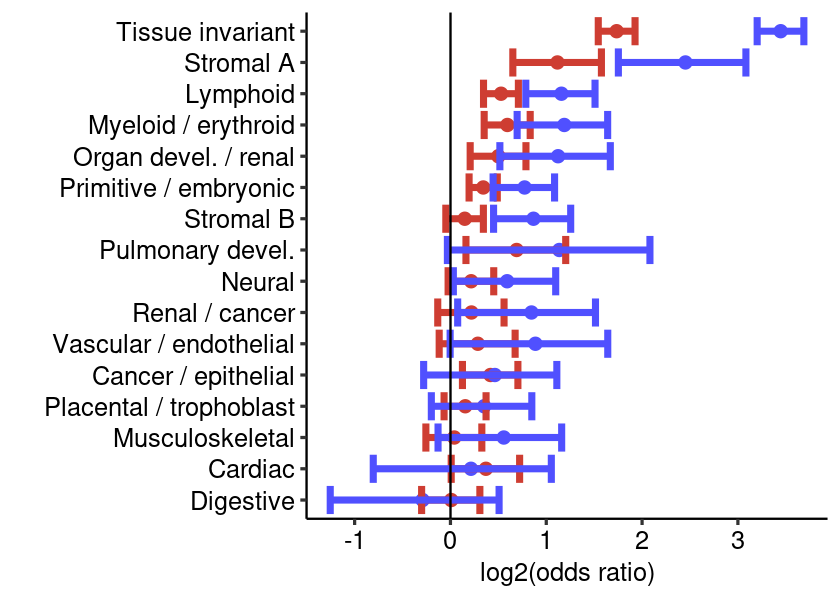

In [21]:
options(repr.plot.width = 7, repr.plot.height = 5)
pC 

## GVAT SNP-SELEX

In [22]:
snpselex = fread("zcat annotation/snp-selex/41586_2021_3211_MOESM14_ESM.csv.gz")
snpselex = separate(snpselex,snp,into=c("chrom","pos","ref","alt"),sep="_")
snpselex$pos = as.numeric(snpselex$pos)

In [23]:
mpra.snpselex = merge(mpraStats.tmp,snpselex, by = c("chrom","pos","ref","alt"))
mpra.snpselex$concord = ifelse(sign(mpra.snpselex$log2FoldChange_allele) == sign(mpra.snpselex$deltasvm_score),"Yes","No")

In [24]:
mpra.snpselex$hit = NA
mpra.snpselex$hit[which(mpra.snpselex$padj_allele < 5e-2 & mpra.snpselex$padj_expr < 5e-2)] = "hit"
mpra.snpselex$hit[which(mpra.snpselex$padj_allele > 0.5 & mpra.snpselex$padj_expr > 0.5)] = "nonhit"

mpra.snpselex$group = "Nonhit"
mpra.snpselex$group[which(mpra.snpselex$hit == "hit" & mpra.snpselex$log2FoldChange_allele > 0)] = "Up"
mpra.snpselex$group[which(mpra.snpselex$hit == "hit" & mpra.snpselex$log2FoldChange_allele < 0)] = "Down"

In [25]:
idx=which( mpra.snpselex$hit == "hit")
fisher.test(mpra.snpselex$effect[idx], mpra.snpselex$log2FoldChange_allele[idx] > 0)


	Fisher's Exact Test for Count Data

data:  mpra.snpselex$effect[idx] and mpra.snpselex$log2FoldChange_allele[idx] > 0
p-value = 3.429e-15
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.328862 8.161388
sample estimates:
odds ratio 
  5.184538 


In [26]:
idx=which( mpra.snpselex$hit == "nonhit")
fisher.test(mpra.snpselex$deltasvm_score[idx] > 0, mpra.snpselex$log2FoldChange_allele[idx] > 0)


	Fisher's Exact Test for Count Data

data:  mpra.snpselex$deltasvm_score[idx] > 0 and mpra.snpselex$log2FoldChange_allele[idx] > 0
p-value = 0.6333
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8672672 1.2719453
sample estimates:
odds ratio 
    1.0502 


In [27]:
geneExp = read.table("annotation/GM12878-geneExp-TPM.tsv",sep='\t',stringsAsFactors = F,header = T)
geneExp = geneExp[,c(2,15:21)]
geneExp[is.na(geneExp)] = 0

concordCounts = mpra.snpselex %>% 
                    group_by(tf,concord,hit) %>% 
                    summarize("count" = n()) %>% 
                    spread(concord, count, fill = 0)

concordCounts$propConcord = concordCounts$Yes/(concordCounts$No + concordCounts$Yes)
concordCounts = merge(subset(concordCounts,Yes+No >= 3),
                      geneExp,
                      by.x="tf",
                      by.y="Gene.Name")

concordCounts$hit = factor(concordCounts$hit, levels = c("nonhit","hit"))

`summarise()` regrouping output by 'tf', 'concord' (override with `.groups` argument)



In [28]:
dim(subset(concordCounts,Yes+No>=3 & hit == "hit"))
dim(subset(concordCounts,Yes+No>=3 & hit == "nonhit"))

mean(unlist(subset(concordCounts,Yes+No>=3 & hit == "hit", select=propConcord)))
mean(unlist(subset(concordCounts,Yes+No>=3 & hit == "nonhit", select=propConcord)))

[1] 59 12

[1] 91 12

[1] 0.7328832

[1] 0.504832

In [29]:
summary(glm(cbind(Yes,No)~hit,
                data=subset(concordCounts,!is.na(hit)),
                family="binomial"))


Call:
glm(formula = cbind(Yes, No) ~ hit, family = "binomial", data = subset(concordCounts, 
    !is.na(hit)))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.39777  -0.55799  -0.09077   0.86968   2.32194  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.05039    0.04842   1.041    0.298    
hithit       0.87595    0.12824   6.830 8.46e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 212.24  on 149  degrees of freedom
Residual deviance: 161.95  on 148  degrees of freedom
AIC: 538.4

Number of Fisher Scoring iterations: 4


In [30]:
options(repr.plot.width = 8, repr.plot.height=9)
pD = ggplot(subset(mpra.snpselex, !is.na(hit)))+
    geom_density_ridges(aes(fill = ifelse(log2FoldChange_allele < 0,"Down","Up"),
                            y = factor(hit,levels=c("nonhit","hit")),
                            x = deltasvm_score),
                        alpha = 0.5,
                        scale = 0.95) +
    theme_pubr(base_size = 15) + 
    scale_fill_manual(name = "MPRA Allelic Effect Direction", values = c("magenta","darkgreen")) +
    scale_y_discrete(expand = expansion(add = c(0.05, 1))) + ylab("")+xlab("SNP-SELEX deltaSVM score")+
    theme( axis.text.y = element_blank())

In [87]:
# pD = ggplot(subset(concordCounts,!is.na(hit))) + 
#                 geom_density(aes(x= propConcord,  fill = hit),alpha = 0.75, bw=0.05) +
#                 theme_pubr(base_size = 15) + 
#                 scale_fill_manual(values = c(pal_igv()(2)[2],"black")) +
#                 xlab("") + 
#                 xlim(c(0,1)) +
#                 xlab("Proportion Concordant with SNP-SELEX") +
#                 theme(legend.position = "none")

pF = ggplot(subset(concordCounts,!is.na(hit))) + 
        geom_density(data = concordCounts, 
                     aes(x = propConcord, y = ..density..*2, color = hit), size = 1.5,alpha=0.5) +
        geom_point(data = subset(concordCounts,hit == "hit"),
                   aes(x = propConcord,
                       y = log2(whole.cell..long.polyA.RNA..GM12878+1),
                       color=hit,
                       fill=hit),
                   position="jitter",
                   size=5)  +  
        scale_color_manual(values = c("hit" = "red", "nonhit" = "black")) +
        ylab("GM12878 RNA-Seq Log2(TPM)") +
        xlab("Proportion Concordant") + 
        geom_text_repel(data = subset(concordCounts,hit == "hit" & log2(whole.cell..long.polyA.RNA..GM12878+1) > 1 & (propConcord >= 0.75 | propConcord < 0.45)),
                        aes(x = propConcord, y = log2(whole.cell..long.polyA.RNA..GM12878+1),label = tf), size=6,box.padding = 0.5,force=20,min.segment.length = 0) +
        geom_vline(xintercept = 0.5) +
        theme_pubr(base_size = 15) +
        xlim(c(0,1.01)) +
        theme(legend.position = "none")

Picking joint bandwidth of 4.42



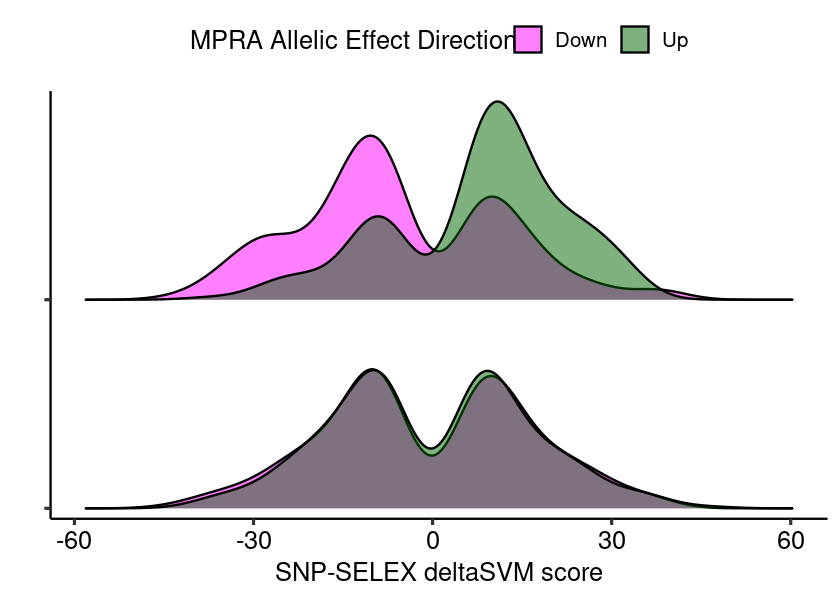

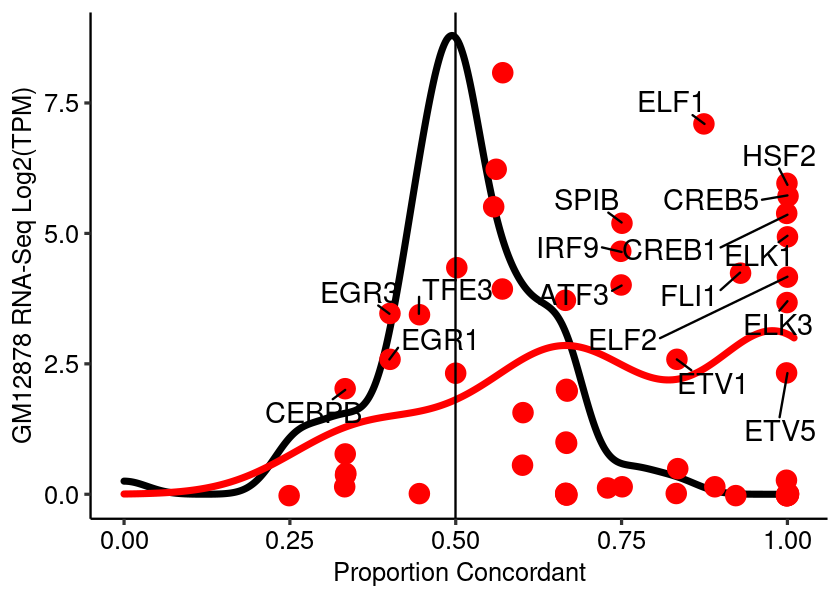

In [88]:
options(repr.plot.width = 7, repr.plot.height = 5)
pD
pF

## ENCODE CHROMATIN ACCESSIBILITY FOOTPRINTS

In [42]:
encode.caqtl = fread("zcat annotation/tested_snvs_padj.bed.gz")
encode.caqtl = unique(encode.caqtl[,c(1,2,3,4,5,9,10,11,12)])
names(encode.caqtl) = c("chrom","start","stop","ref","alt","ratio","pval","padj","inDHS")

encode.caqtl = merge(encode.caqtl, hgConvTable,
                     by.x = c("chrom","stop"), by.y = c("hg38_chrom","hg38_pos"))

mpra.caqtl = merge(mpraStats.tmp, encode.caqtl, 
                   by.x = c("chrom","pos","ref","alt"),
                   by.y = c("hg19_chrom","hg19_pos","ref","alt"), all.x = T)

#mpra.caqtl$padj[is.na(mpra.caqtl$padj)] = 1
mpra.caqtl$inDHS[is.na(mpra.caqtl$inDHS)] = NA

In [43]:
caQTL.TF = fread("zcat annotation/tested_snvs_padj_TFs.txt.gz")[,-2]
names(caQTL.TF) = c("chrom","pos","ref","alt","TF")

caQTL.TF = merge(caQTL.TF, hgConvTable,
                 by.x = c("chrom","pos"), by.y = c("hg38_chrom","hg38_pos"))

mpra.caqtl.tf = merge(mpra.caqtl[,c(1:4,9:11,16:19)], caQTL.TF, 
                   by.x = c("chrom","pos","ref","alt"),
                      by.y = c("hg19_chrom","hg19_pos","ref","alt"), all.x = T)

mpra.caqtl.tf$inDHS = ifelse(mpra.caqtl.tf$inDHS == 0, "Outside DHS Peak","Inside DHS Peak")

Picking joint bandwidth of 0.0371



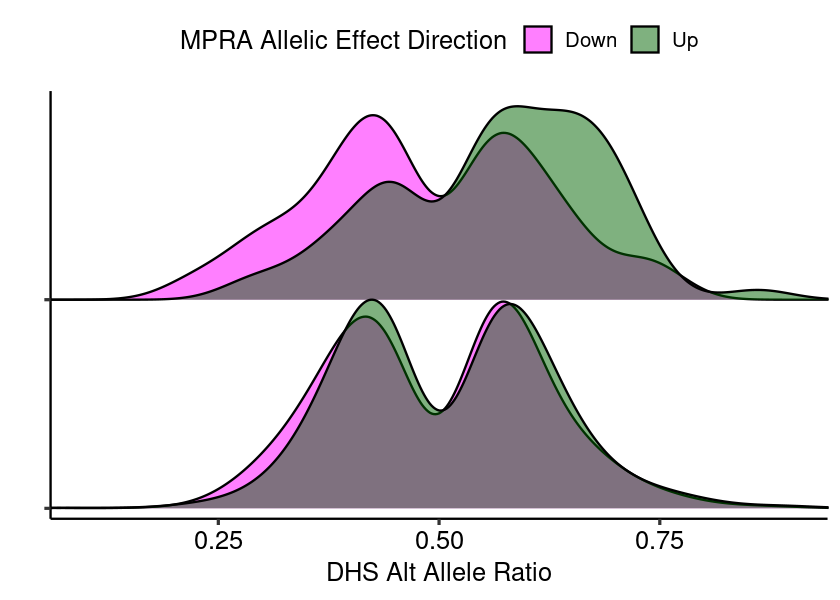

In [55]:
densities = subset(mpra.caqtl.tf,
                          inDHS=="Inside DHS Peak" & pval < 0.5) 

options(repr.plot.width = 7, repr.plot.height = 5)

ggplot(densities) +
    geom_density_ridges(aes(y = padj_expr < 5e-2 & padj_allele < 5e-2 ,
                            x = abs(1-ratio),
                            fill = ifelse(log2FoldChange_allele > 0,"Up","Down")),
                        alpha=0.5,
                        scale = 1) +
    theme_pubr(base_size = 15) +
    scale_fill_manual(name = "MPRA Allelic Effect Direction   ", values = c("magenta","darkgreen")) +
    scale_y_discrete(expand = expansion(add = c(0.05, 1)))+ ylab("") + theme(axis.text.y=element_blank())+ 
    xlab("DHS Alt Allele Ratio") + coord_cartesian(xlim=c(0.1,0.9))

In [57]:
p = subset(mpra.caqtl.tf,inDHS=="Inside DHS Peak" & pval < 0.5 & padj_allele > 5e-2 & padj_expr > 5e-2)
fisher.test(sign(p$log2FoldChange_allele), sign(0.5-p$ratio))

p = subset(mpra.caqtl.tf,inDHS=="Inside DHS Peak" & pval < 0.5 & padj_allele < 5e-2 & padj_expr < 5e-2)
fisher.test(sign(p$log2FoldChange_allele), sign(0.5-p$ratio))


	Fisher's Exact Test for Count Data

data:  sign(p$log2FoldChange_allele) and sign(0.5 - p$ratio)
p-value = 0.8392
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.835373 1.256115
sample estimates:
odds ratio 
  1.024363 



	Fisher's Exact Test for Count Data

data:  sign(p$log2FoldChange_allele) and sign(0.5 - p$ratio)
p-value = 0.007327
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.291951 6.224745
sample estimates:
odds ratio 
  2.801076 


In [70]:
mpra.caqtl.tf.sep = separate_rows(mpra.caqtl.tf, TF, sep = ";")
mpra.caqtl.tf.sep = subset(mpra.caqtl.tf.sep, inDHS=="Inside DHS Peak" & pval < 0.5)

mpra.caqtl.tf.sep$hit = ifelse(mpra.caqtl.tf.sep$padj_allele<5e-2 & 
                               mpra.caqtl.tf.sep$padj_expr<5e-2,"hit","nonhit")

concord.TF = mpra.caqtl.tf.sep %>%
                mutate(log2FoldChange_allele = ifelse(sign(log2FoldChange_allele) == -1, "Down","Up"),
                       ratio = ifelse(sign(0.5-ratio) == -1, "Down","Up")) %>%
                group_by(TF, log2FoldChange_allele, ratio, hit) %>%
                summarize("count"  = n())

concord.TF$concord = "No"
concord.TF$concord[which(concord.TF$log2FoldChange_allele == concord.TF$ratio)] = "Yes"

concord.TF.sums = concord.TF %>% 
                    group_by(TF, concord, hit) %>% 
                    summarize(count = sum(count)) %>% 
                    spread(concord, count,fill=0)

concord.TF.sums = subset(concord.TF.sums, TF != "" & TF != 0)

`summarise()` regrouping output by 'TF', 'log2FoldChange_allele', 'ratio' (override with `.groups` argument)

`summarise()` regrouping output by 'TF', 'concord' (override with `.groups` argument)



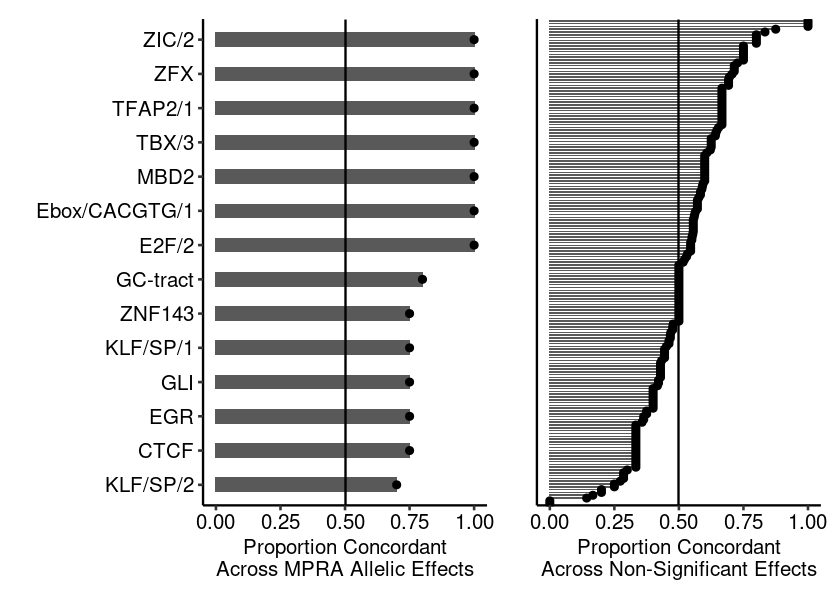

In [72]:
group1 = subset(concord.TF.sums, No+Yes>=3 & hit == "hit")
group2 = subset(concord.TF.sums, No+Yes>=3 & hit == "nonhit")

p1 = ggplot(group1)+
        geom_bar(aes(y = reorder(TF,Yes/(No+Yes)), x = Yes/(No+Yes)), stat = "identity",width=0.4) +
        geom_point(aes(y = reorder(TF,Yes/(No+Yes)), x = Yes/(No+Yes))) +
        theme_pubr(base_size = 12) +
        geom_vline(xintercept = 0.5) +
        xlab("Proportion Concordant\nAcross MPRA Allelic Effects") + ylab("")

p2 = ggplot(group2)+
        geom_bar(aes(y = reorder(TF,Yes/(No+Yes)), x = Yes/(No+Yes)), stat = "identity",width=0.2) +
        geom_point(aes(y = reorder(TF,Yes/(No+Yes)), x = Yes/(No+Yes))) +
        theme_pubr(base_size = 12) +
        geom_vline(xintercept = 0.5) + 
        theme(axis.text.y = element_blank(),
              axis.ticks.y = element_blank()) +
        xlab("Proportion Concordant\nAcross Non-Significant Effects")+ ylab("")

options(repr.plot.width = 7, repr.plot.height = 5)
p1+p2 + plot_layout(design = "AAABBB")

In [73]:
caqtl.scatter = ggplot(subset(mpra.caqtl.tf, padj < 1),
                       aes(x = log2FoldChange_allele, y = abs(1-ratio), 
                       color = padj_allele < 5e-2 & padj_expr <5e-2 & pval<0.25,
                       alpha = ifelse(padj_allele < 5e-2 & padj_expr <5e-2 & pval<0.25, 1,0.25))) + 
    geom_point(size = 4) +
    theme_pubr(base_size = 20) + 
    scale_color_manual(values = c("black","red")) + 
    facet_wrap(~inDHS,ncol=2) +
    theme(legend.position = "none") + 
    xlab("MPRA Allelic Effect Size") + ylab("DHS Alt Allele Proportion") + 
    theme(strip.background = element_blank(), strip.placement = "outside", strip.text = element_text(size=20))

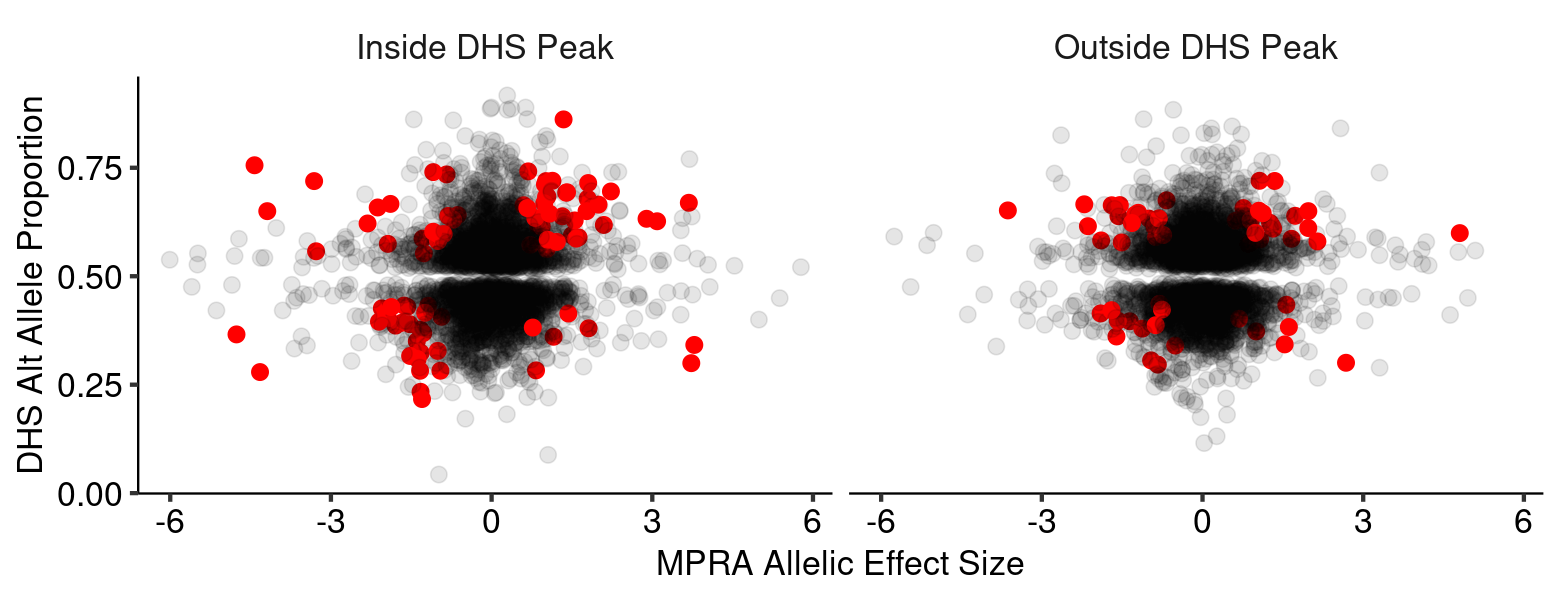

In [74]:
options(repr.plot.height = 5, repr.plot.width =13 )
caqtl.scatter + theme(legend.position = "none")

In [75]:
p = subset(mpra.caqtl.tf, padj_allele < 5e-2 & padj_expr < 5e-2 & padj < 1 & inDHS == "Outside DHS Peak")
fisher.test(sign(p$log2FoldChange_allele), sign(0.5-p$ratio))

p = subset(mpra.caqtl.tf, padj_allele < 5e-2 & padj_expr < 5e-2 & padj < 1 & inDHS == "Inside DHS Peak")
fisher.test(sign(p$log2FoldChange_allele), sign(0.5-p$ratio))


	Fisher's Exact Test for Count Data

data:  sign(p$log2FoldChange_allele) and sign(0.5 - p$ratio)
p-value = 0.4796
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6174923 2.8193122
sample estimates:
odds ratio 
  1.314755 



	Fisher's Exact Test for Count Data

data:  sign(p$log2FoldChange_allele) and sign(0.5 - p$ratio)
p-value = 0.001776
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.437168 5.605112
sample estimates:
odds ratio 
  2.812738 


## FAVOR + ENFORMER

In [76]:
favor = fread("annotation/allFavor.csv") %>% 
                separate(Variant,c("chrom","pos","ref","alt"),"-")

favor = unique(favor)
favor$pos = as.numeric(favor$pos)

favor = merge(favor, hgConvTable, 
                    by.x = c("chrom","pos"), 
                    by.y = c("hg38_chrom","hg38_pos"))

mpra.favor = merge(mpraStats.tmp, favor,
                   by.x= c("chrom","pos","ref","alt"),
                   by.y = c("hg19_chrom","hg19_pos","ref","alt"))

mpra.favor$hit = ifelse(mpra.favor$padj_expr <= 5e-2 & mpra.favor$padj_allele<= 5e-2, "Yes","No")
mpra.favor.apc = melt(mpra.favor[,c("hit","aPC-Transcription-Factor","aPC-Proximity-To-TSS-TES","aPC-Epigenetics")])
mpra.favor.apc$perc = 10^(mpra.favor.apc$value/-10)

Warning message in melt.data.table(mpra.favor[, c("hit", "aPC-Transcription-Factor", :
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [hit]. Consider providing at least one of 'id' or 'measure' vars in future.”


In [77]:
enformerPCs = fread("annotation/enformerPCs.txt")
backgroundPCs = fread("annotation/enformerPCs_chr22_background.txt")

mpraStats.enformer = merge(mpraStats.tmp, enformerPCs, by.x = c("chrom","pos","ref","alt"), by.y = c("V1","V2","V4","V5"))
mpraStats.enformer$hit = ifelse(mpraStats.enformer$padj_allele < 5e-2 & 
                                mpraStats.enformer$padj_expr < 5e-2,
                                "Yes","No")

pc1 = c(mpraStats.enformer$V6,backgroundPCs$PC0)
pc1 = 1-(rank(abs(pc1))/length(pc1))

pc2 = c(mpraStats.enformer$V7,backgroundPCs$PC1)
pc2 = 1-(rank(abs(pc2))/length(pc2))

enfRanks = c(pc1,pc2)

enfPlot = data.frame("variable" = c(rep("EnformerPC1",length(pc1)),rep("EnformerPC2",length(pc2))),
                     "perc" = enfRanks,
                     "hit" = rep(c(mpraStats.enformer$hit,
                                rep("background",length(backgroundPCs$PC0))),2),
                    stringsAsFactors = F)
enfPlot = subset(enfPlot, hit != "background")

In [78]:
p.favor = ggplot(mpra.favor.apc, aes(x = perc,color = variable,linetype = hit)) + 
    geom_abline(slope = 1, intercept = 0, color = "magenta") +
    stat_ecdf() + 
    theme_pubr(base_size = 16) +
    scale_color_manual(values = c("aPC-Transcription-Factor" = "red",
                                  "aPC-Proximity-To-TSS-TES" = "darkgreen",
                                  "aPC-Epigenetics" = "navy")) +
    scale_linetype_manual(values = c("Yes" = 4, "No" = 1)) +
    ylab("") + xlab("") +
    theme(legend.position = "none")

In [79]:
p.enformer = ggplot(enfPlot, aes(x = perc,color = variable,linetype = hit)) + 
    geom_abline(slope = 1, intercept = 0, color = "magenta") +
    stat_ecdf() +
    theme_pubr(base_size = 16) +
    scale_color_manual(values = c("EnformerPC1" = "red",
                                  "EnformerPC2" = "blue")) +
    scale_linetype_manual(values = c("Yes" = 4, "No" = 1)) +
    ylab("") + xlab("") +
    theme(legend.position = "none")

Warning message:
“Removed 13464 rows containing non-finite values (stat_ecdf).”
Warning message:
“Removed 13464 rows containing non-finite values (stat_ecdf).”


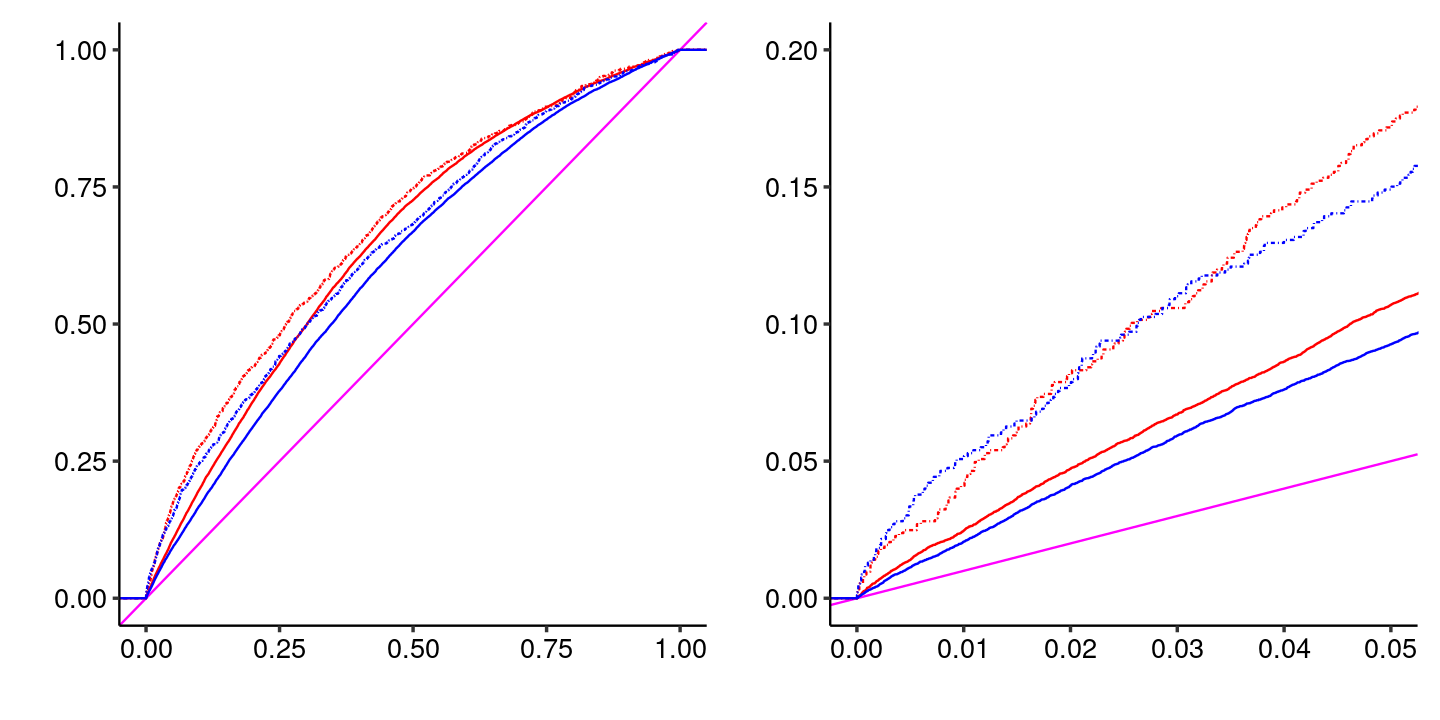

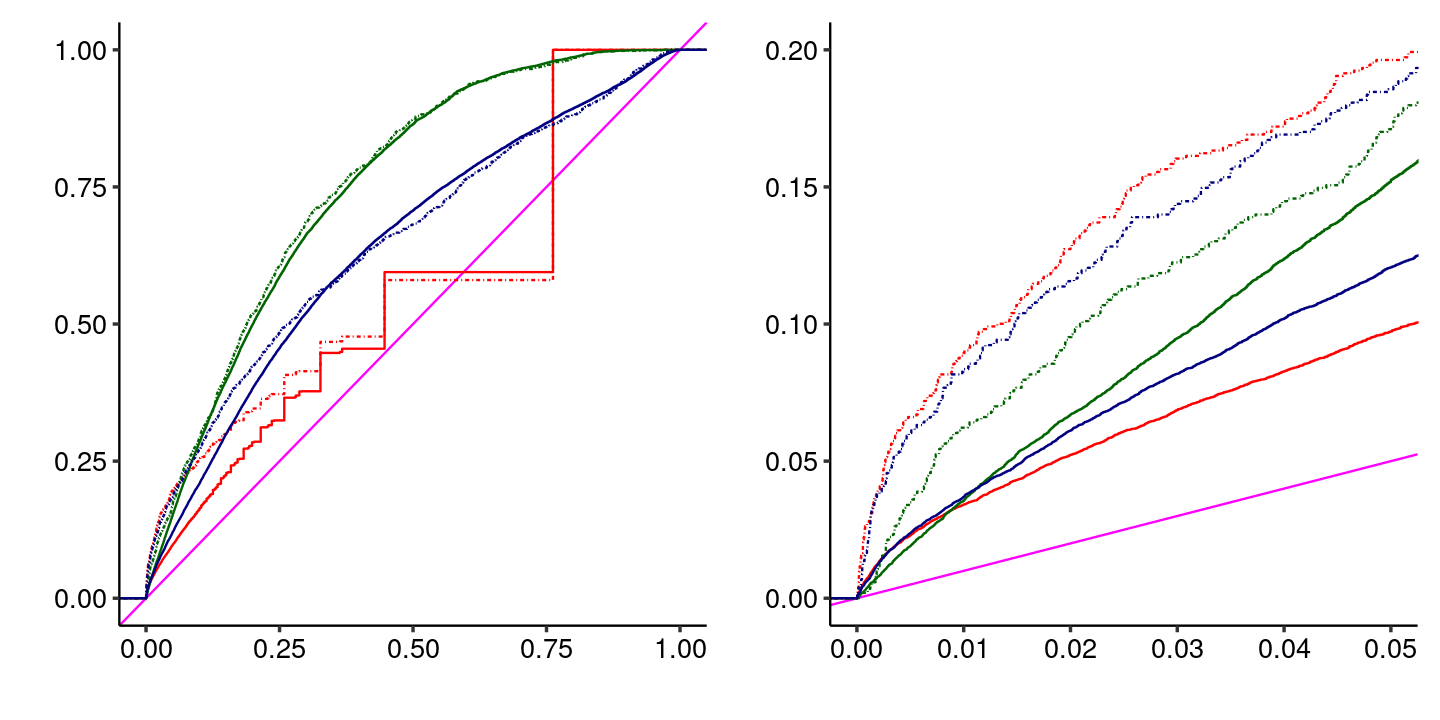

In [80]:
options(repr.plot.width = 12, repr.plot.height = 6)
p.enformer + (p.enformer & coord_cartesian(xlim=c(0,0.05), ylim = c(0,0.2)))
p.favor + (p.favor & coord_cartesian(xlim=c(0,0.05), ylim = c(0,0.2)))

## CHROMHMM

In [81]:
chromHmm = fread('annotation/GM12878-ChromHMM-EpiMap.txt', drop=3, col.names = c("chrom","pos","chromHmmState"), header = F)
chromHmmStateIDs = fread('annotation/chromHmmStateIDs.txt', col.names = c("label","shortID","name","color","colorRGB"), header = F)
chromHmm$pos = as.numeric(chromHmm$pos)

chromHmm = merge(chromHmm, hgConvTable, 
                    by.x = c("chrom","pos"), 
                    by.y = c("hg38_chrom","hg38_pos"))
mpra.chromHmm = merge(mpraStats.tmp, chromHmm,
                   by.x= c("chrom","pos"),
                   by.y = c("hg19_chrom","hg19_pos"))

stateCounts = as.data.frame(table(mpra.chromHmm$chromHmmState),stringsAsFactors = F)
names(stateCounts) = c("label","count")

In [82]:
hitList = ifelse(mpra.chromHmm$padj_expr<5e-2 & mpra.chromHmm$padj_allele < 5e-2,"hit","nonhit")

oddsRatios = computeOddsRatiosVsAll(hitList,mpra.chromHmm$chromHmmState)
oddsRatios = merge(oddsRatios, chromHmmStateIDs, by = "label")
oddsRatios = merge(oddsRatios, stateCounts, by = "label")
oddsRatios = subset(oddsRatios, label != "E14")

pChromHmm = ggplot(data = oddsRatios) + 
    geom_errorbarh(aes(y = reorder(name, -fisher.exact.bh),
                       xmin = log2(lower),
                       xmax = log2(upper)),
                    stat = "identity",
                    color = ifelse(oddsRatios$fisher.exact.bh <= 5e-2,"red","black")) +
    geom_point(aes(y = reorder(name, log2(lower) + log2(or)),
                   x = log2(or)),
               stat = "identity",
               color = ifelse(oddsRatios$fisher.exact.bh <= 5e-2,"red","black")) +
    geom_vline(aes(xintercept = 0), color = "red") + 
    geom_text(aes(y = reorder(name, log2(lower) + log2(or)),
                  x = 3,
                  label = count))+
    theme_pubr(base_size = 15) + 
    theme(axis.title.y = element_blank()) + 
    xlab("log2(odds ratio)") + ylab("")

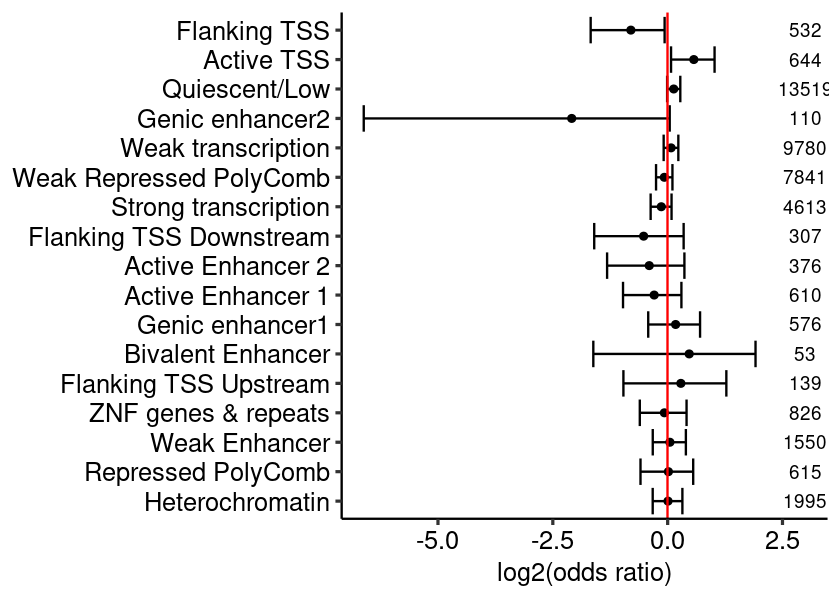

In [83]:
options(repr.plot.width = 7, repr.plot.height = 5)
pChromHmm

In [84]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.3.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggsci_2.9          openxlsx_4.2.3     fs_1.5.0           pROC_1.16.2       
 [5] naniar_0.6.0       ggExtra_0.9        epitools_0.5-10.1  ggridges_0.5.2    
 [9] patchwork_1.1.0    ggpubr_0.4.0       data.table_1.13.2  ggrepel_0.8.2     
[13] viridis_0.5.1      viridisLite_0.3.0  RColorBrewer_1.1-2 GGally_2.0.0      
[17] forcat